In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import skew, kurtosis
import pywt
%matplotlib inline

In [4]:
folder_path = 'D:/semester 6/asb/TrainCSV_C23'
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
df = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)

In [5]:
print(df.head())

    Chan_1  Chan_2   Chan_3   Chan_4  Chan_5  Marker  Label  MSegment  \
0 -0.98361  2.3850  0.16894 -5.83180  7.7655       0      1         0   
1 -2.78720  3.6848  0.46813 -3.33240  6.6764       0      1         0   
2 -4.64180  5.5209  0.87631  0.25521  5.4315       0      1         0   
3 -4.49610  6.0093  0.87267  4.25570  4.4209       0      1         0   
4 -3.18470  5.7445  0.68643  6.55530  3.6460       0      1         0   

   Repition  Trial  
0         1      1  
1         1      1  
2         1      1  
3         1      1  
4         1      1  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800000 entries, 0 to 79799999
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Chan_1    float64
 1   Chan_2    float64
 2   Chan_3    float64
 3   Chan_4    float64
 4   Chan_5    float64
 5   Marker    int64  
 6   Label     int64  
 7   MSegment  int64  
 8   Repition  int64  
 9   Trial     int64  
dtypes: float64(5), int64(5)
memory usage: 5.9 GB
None


In [7]:
# --- Konfigurasi ---
fs = 2000  # sampling rate
segment_size = 1000  # panjang tiap segmen
emg_cols = ['Chan_1', 'Chan_2', 'Chan_3', 'Chan_4', 'Chan_5']

In [8]:
# --- Fungsi Filtering & Denoising ---
def notch_filter(data, fs, freq=50.0, Q=30.0, plot=False, ch=None):
    b, a = iirnotch(freq, Q, fs)
    filtered = filtfilt(b, a, data)
    if plot and ch is not None:
        plt.figure(figsize=(10, 3))
        plt.plot(data, label='Original', alpha=0.6)
        plt.plot(filtered, label='After Notch', alpha=0.7)
        plt.title(f'Notch Filter - Channel {ch}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return filtered

In [9]:
def lowpass_filter(data, fs, cutoff=150, order=4, plot=False, ch=None):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    filtered = filtfilt(b, a, data)
    if plot and ch is not None:
        plt.figure(figsize=(10, 3))
        plt.plot(data, label='Before Lowpass', alpha=0.6)
        plt.plot(filtered, label='After Lowpass', alpha=0.7)
        plt.title(f'Lowpass Filter - Channel {ch}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return filtered

In [10]:
def wavelet_denoise(signal, wavelet='sym4', level=3, plot=False, ch=None):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(signal)))
    coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
    denoised = pywt.waverec(coeffs_thresh, wavelet)
    denoised = denoised[:len(signal)]  # crop to original length
    if plot and ch is not None:
        plt.figure(figsize=(10, 3))
        plt.plot(signal, label='Before Wavelet', alpha=0.6)
        plt.plot(denoised, label='After Wavelet', alpha=0.7)
        plt.title(f'Wavelet Denoising - Channel {ch}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return denoised

In [11]:
def bandpass_filter(data, lowcut=20, highcut=450, fs=2000, order=4):
    nyquist = 0.5 * fs
    b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
    return filtfilt(b, a, data)

In [12]:
def process_signal(signal, fs, ch=None, plot=False):
    if plot and ch is not None:
        plt.figure(figsize=(12, 3))
        plt.plot(signal, label='Original', alpha=0.5)

    notch = notch_filter(signal, fs, plot=False)
    low = lowpass_filter(notch, fs, plot=False)
    wave = wavelet_denoise(low, plot=False)

    if plot and ch is not None:
        plt.plot(wave, label='Filtered + Denoised', alpha=0.8)
        plt.title(f'Channel {ch} - Original vs Final')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return np.abs(wave)

In [13]:
# --- Fungsi Ekstraksi dan Deteksi ---
def extract_all_features(segment, fs):
    features = []
    for i in range(segment.shape[1]):
        channel = segment[:, i]

        # Time-domain features
        mean = np.mean(channel)
        std = np.std(channel)
        min_val = np.min(channel)
        max_val = np.max(channel)
        median = np.median(channel)
        mav = np.mean(np.abs(channel))
        rms = np.sqrt(np.mean(channel**2))
        skewness = skew(channel)
        kurt = kurtosis(channel)

        # Frequency-domain features
        freqs = np.fft.rfftfreq(len(channel), d=1/fs)
        fft_vals = np.abs(np.fft.rfft(channel))
        spectral_mean = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        spectral_entropy = -np.sum((fft_vals/np.sum(fft_vals)) * np.log(fft_vals/np.sum(fft_vals) + 1e-10))
        dominant_freq = freqs[np.argmax(fft_vals)]

        features.extend([
            mean, std, min_val, max_val, median, mav, rms, skewness, kurt,
            spectral_mean, spectral_entropy, dominant_freq
        ])
    return np.array(features)

In [14]:
def detect_onset_offset(signal, threshold=0.05):
    active = signal > threshold
    transitions = np.diff(active.astype(int))
    onsets = np.where(transitions == 1)[0]
    offsets = np.where(transitions == -1)[0]
    return onsets, offsets

In [15]:
# --- Label Mapping Sesuai Permintaan ---
def map_faabos_group(label):
    if label == 0:
        return "G0"
    elif label in [2, 9, 10]:
        return "G1"
    elif label in [3, 4, 5, 6, 7, 8]:
        return "G2"
    elif label in [11, 12, 13, 16, 18, 19, 20, 21]:
        return "G3"
    elif label in [1, 17]:
        return "G4"
    elif label in [14, 15]:
        return "G5"
    else:
        return "Unknown"

In [17]:
def load_and_preprocess_all_data(folder_path):
    X, y = [], []
    filtered_all = []
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    already_plotted = False

    for file_path in all_files:
        df = pd.read_csv(file_path)
        df = df[df['Repition'].isin([1, 2, 3])].dropna()
        filtered_all.append(df)
        grouped = df.groupby('Label')

        for label_val, group in grouped:
            group = group.head(3 * segment_size)
            for i in range(0, len(group) - segment_size + 1, segment_size):
                segment = group.iloc[i:i + segment_size]
                
                plot_flag = not already_plotted
                processed = np.stack(
                    [process_signal(segment[ch].values, fs, ch=i+1, plot=plot_flag) for i, ch in enumerate(emg_cols)],
                    axis=1
                )
                already_plotted = True

                features = extract_all_features(processed, fs)
                mapped_label = map_faabos_group(int(label_val))
                if mapped_label != "Unknown":
                    X.append(features)
                    y.append(mapped_label)

    df_all = pd.concat(filtered_all, ignore_index=True)
    # Statistik tambahan
    print("\n--- Statistik Data ---")
    print(f"Jumlah file CSV ditemukan          : {len(all_files)}")
    print(f"Jumlah total data mentah          : {sum([len(pd.read_csv(f)) for f in all_files]):,}")
    print(f"Jumlah total data setelah filter  : {len(df_all):,}")
    print(f"Jumlah total segmen fitur (X)     : {len(X):,}")
    
    label_counts = pd.Series(y).value_counts().sort_index()
    print("\nJumlah data per label (setelah mapping):")
    for label, count in label_counts.items():
        print(f"{label}: {count}")

    
    return X, y, df_all

In [18]:
# --- Pelatihan dan Evaluasi Model ---
def train_and_evaluate(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix FAABOS (G0–G5)')
    plt.tight_layout()
    plt.show()

    return scaler, label_encoder, knn

In [19]:
# --- Visualisasi ---
def plot_segmentation(signal, onsets, offsets, title="Segmentation Result", range_plot=(0, 3000)):
    plt.figure(figsize=(12, 4))
    plt.plot(signal[range_plot[0]:range_plot[1]])
    for o in onsets:
        if range_plot[0] <= o <= range_plot[1]:
            plt.axvline(x=o, color='g', linestyle='--')
    for o in offsets:
        if range_plot[0] <= o <= range_plot[1]:
            plt.axvline(x=o, color='r', linestyle='--')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [20]:
def plot_feature_distribution(df_features):
    selected_features = ['Chan_1_mean', 'Chan_2_std', 'Chan_3_rms', 'Chan_4_mav', 'Chan_5_mean']
    plt.figure(figsize=(15, 10))
    for i, feat in enumerate(selected_features, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(data=df_features, x='Label', y=feat, palette='Set3')
        plt.title(f'Distribusi {feat} per Grup')
    plt.tight_layout()
    plt.suptitle('Visualisasi Fitur Statistik EMG per Grup FAABOS', fontsize=16, y=1.02)
    plt.show()

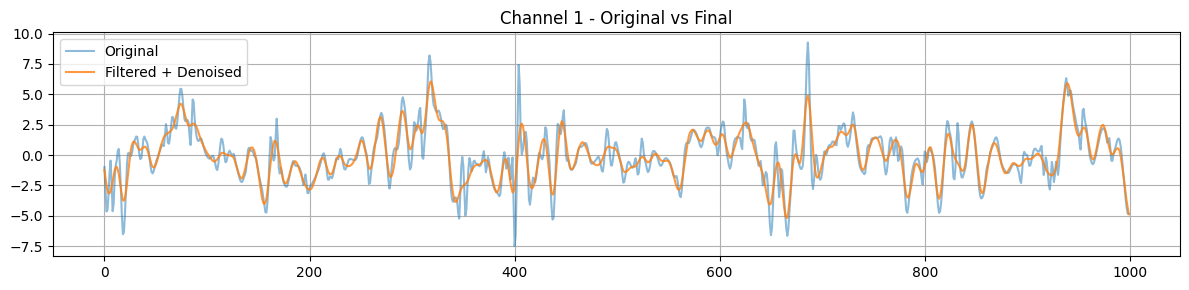

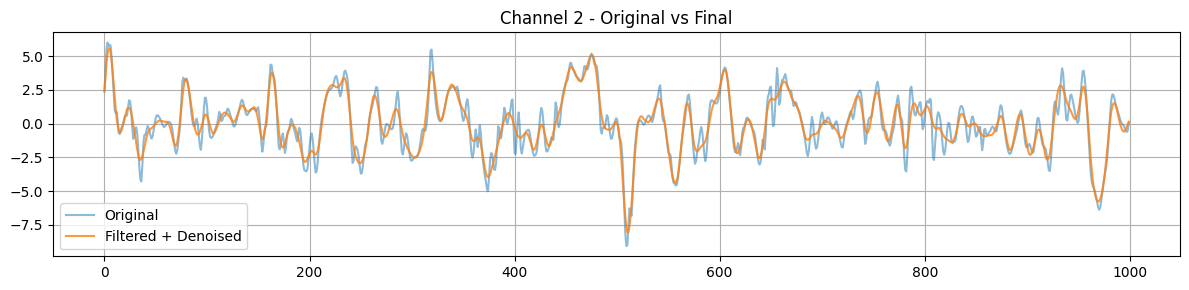

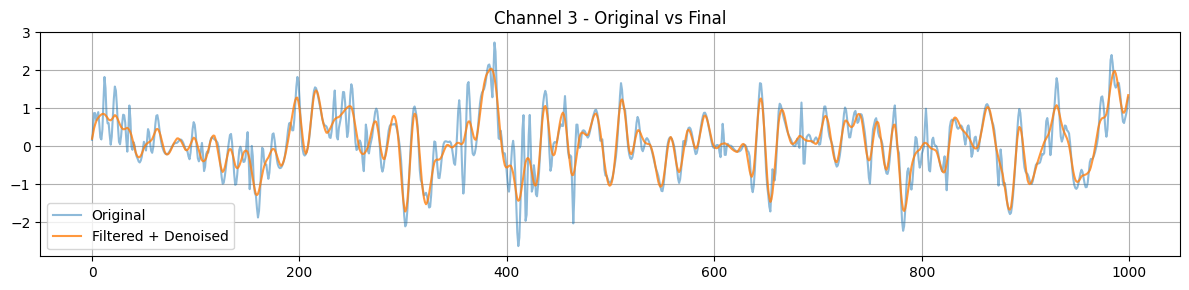

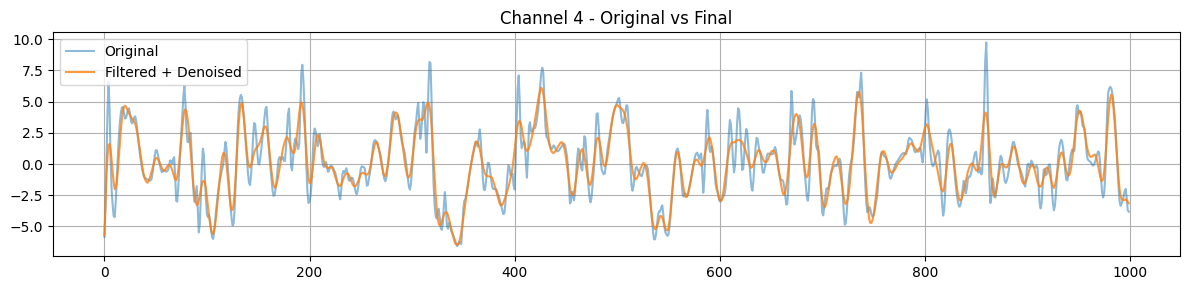

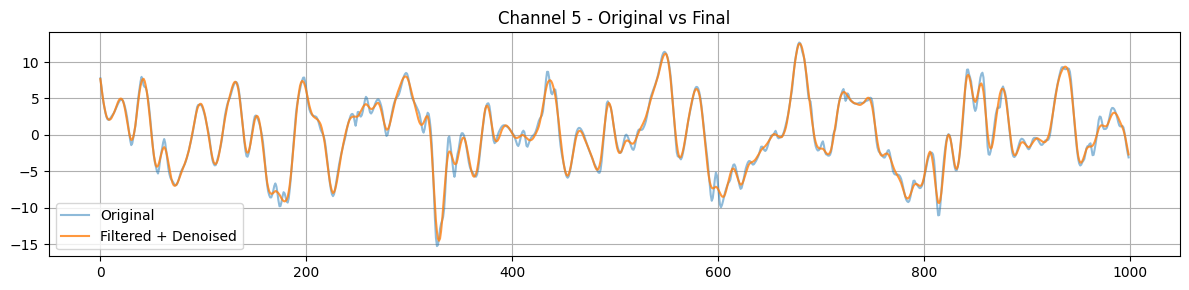


--- Statistik Data ---
Jumlah file CSV ditemukan          : 25
Jumlah total data mentah          : 79,800,000
Jumlah total data setelah filter  : 22,800,000
Jumlah total segmen fitur (X)     : 1,575

Jumlah data per label (setelah mapping):
G1: 225
G2: 450
G3: 600
G4: 150
G5: 150

Classification Report:
              precision    recall  f1-score   support

          G1       0.28      0.20      0.23        45
          G2       0.42      0.52      0.47        90
          G3       0.49      0.67      0.57       120
          G4       0.00      0.00      0.00        30
          G5       0.40      0.07      0.11        30

    accuracy                           0.44       315
   macro avg       0.32      0.29      0.28       315
weighted avg       0.39      0.44      0.39       315


Confusion Matrix:


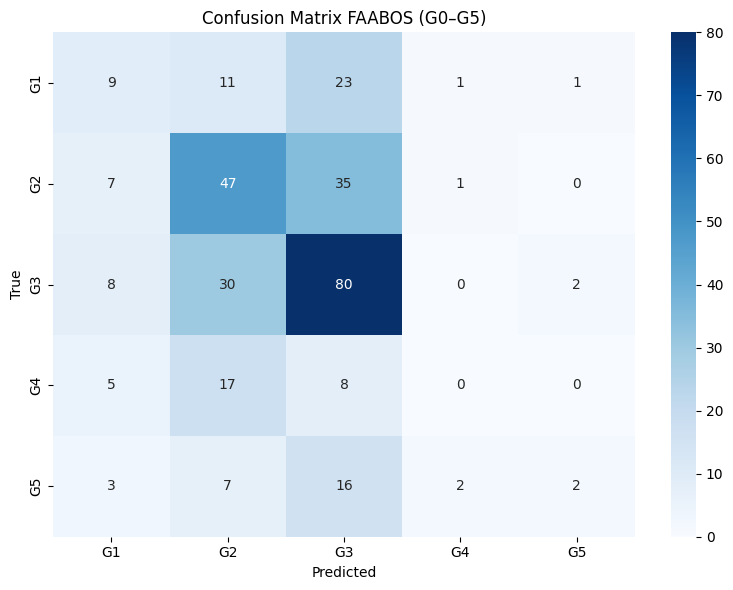

In [21]:
X, y, df_all = load_and_preprocess_all_data(folder_path)
scaler, label_encoder, knn = train_and_evaluate(X, y)

In [22]:
# Simpan fitur dan label
stat_features = ['mean', 'std', 'min', 'max', 'median', 'mav', 'rms', 'zc', 'ssc', 'wl', 'iEMG', 'var']  # total 12 fitur
feature_names = [f'{ch}_{stat}' for ch in emg_cols for stat in stat_features]
df_features = pd.DataFrame(X, columns=feature_names)
df_features['Label'] = y
df_features.to_csv("ekstraksi_fitur_emg.csv", index=False)

In [23]:
# Tambahkan label mapping ke df_all
df_all['Label'] = df_all['Label'].apply(map_faabos_group)
df_all.to_csv('filtered_data.csv', index=False)

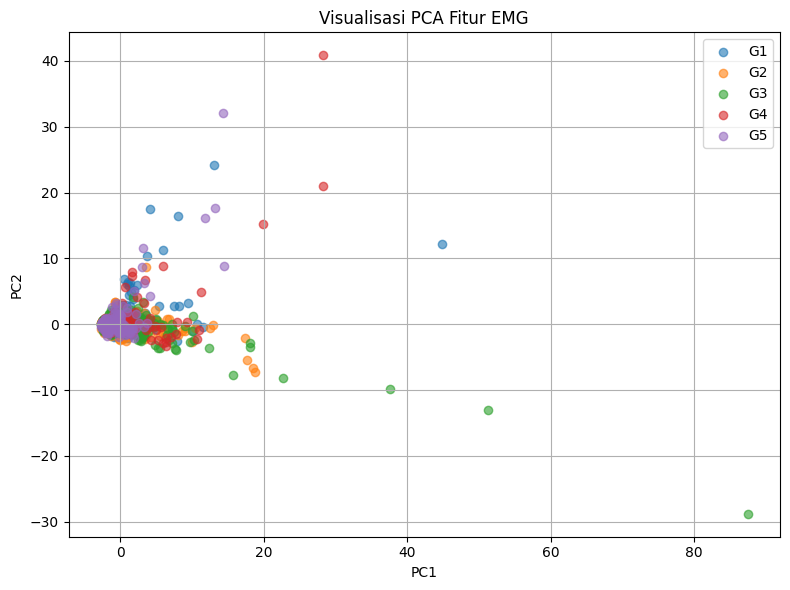

In [27]:
# --- Visualisasi PCA ---
from sklearn.decomposition import PCA

def plot_pca(X, y, label_encoder):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8,6))
    for label in np.unique(y):
        idx = y == label
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label_encoder.inverse_transform([label])[0], alpha=0.6)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Visualisasi PCA Fitur EMG')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pca(scaler.transform(X), label_encoder.transform(y), label_encoder)

In [28]:
# Distribusi label
label_counts = df_all['Label'].value_counts()
print("\nSebaran Data Berdasarkan Label:")
print(label_counts)


Sebaran Data Berdasarkan Label:
Label
G3    9800000
G2    4800000
G5    3500000
G1    2400000
G4    2300000
Name: count, dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3404\3400786598.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='Label', y=feat, palette='Set3')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3404\3400786598.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='Label', y=feat, palette='Set3')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3404\3400786598.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='Label', y=feat, palette='Set3')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3404\3400786

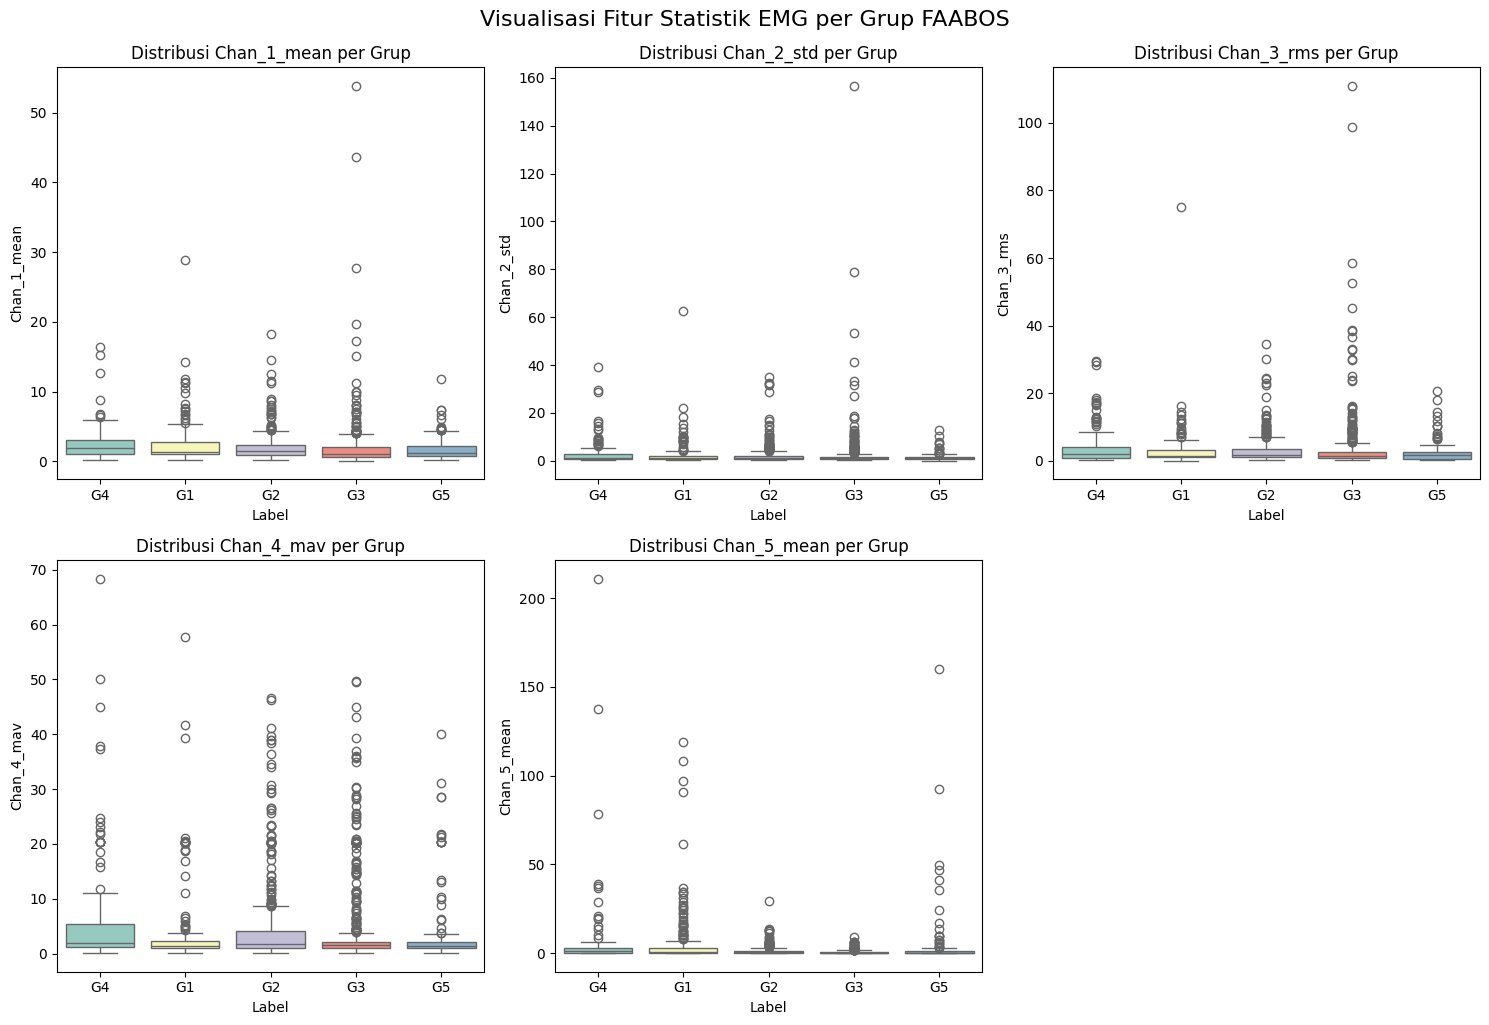

In [29]:
# Visualisasi fitur
plot_feature_distribution(df_features)

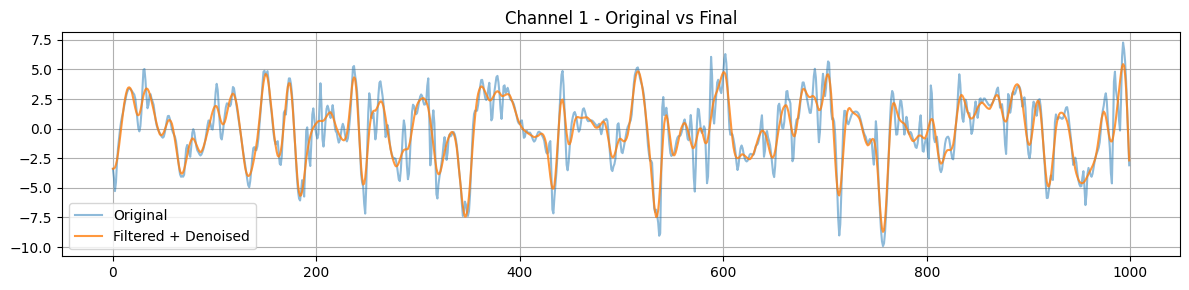

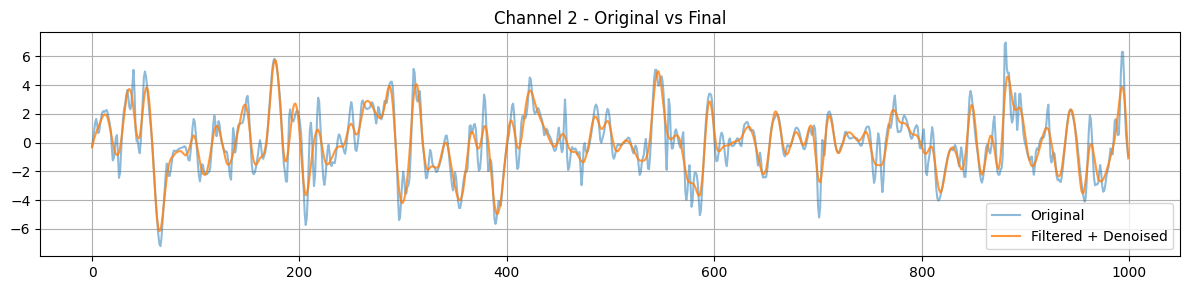

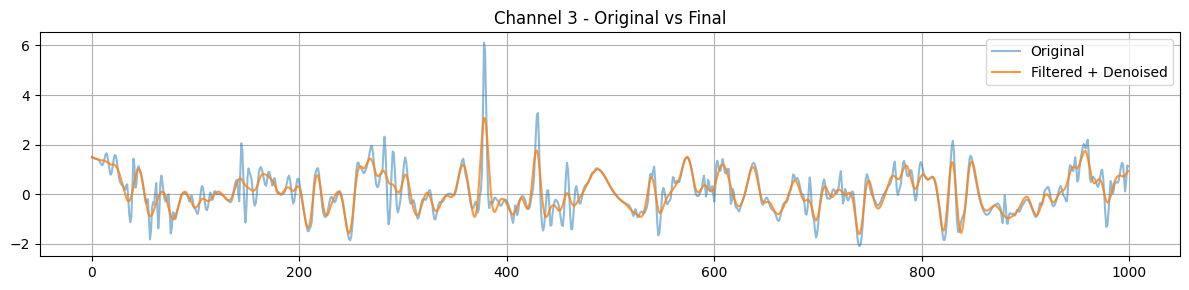

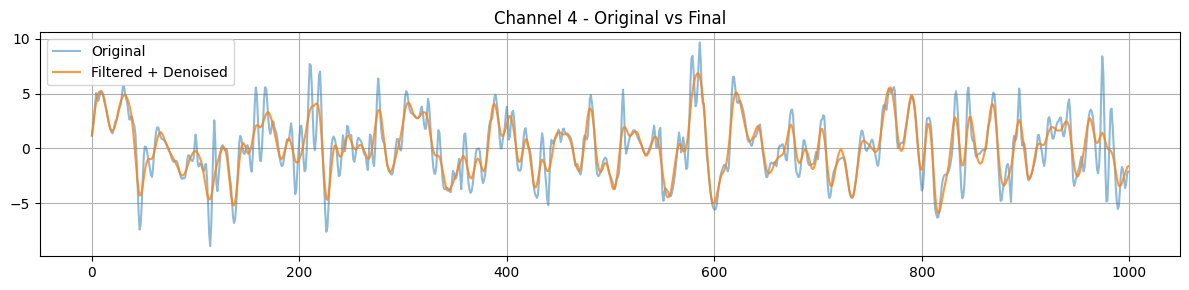

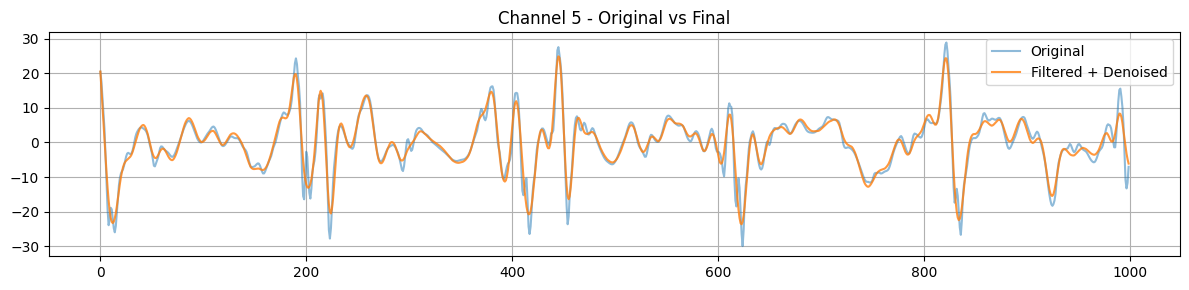


--- Statistik Data ---
Jumlah file CSV ditemukan          : 25
Jumlah total data mentah          : 34,200,000
Jumlah total data setelah filter  : 11,400,000
Jumlah total segmen fitur (X)     : 1,575

Jumlah data per label (setelah mapping):
G1: 225
G2: 450
G3: 600
G4: 150
G5: 150


In [33]:
# Proses data uji (TestCSV_C23)
test_folder = 'D:/semester 6/asb/TestCSV_C23/TestCSV_C23'
test_data = load_and_preprocess_all_data(test_folder)

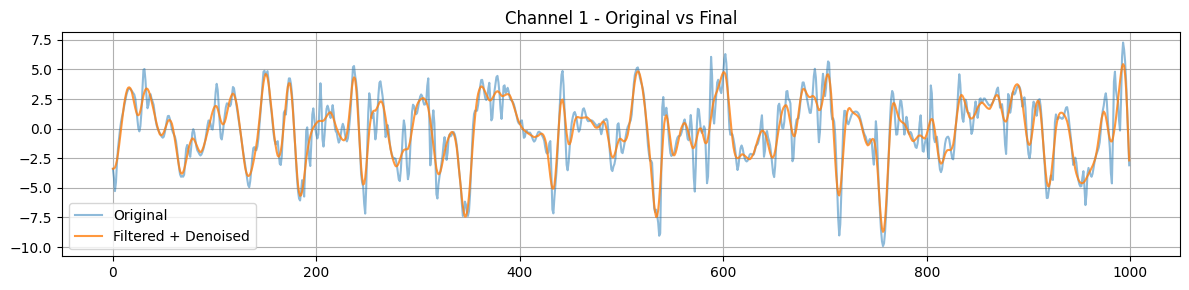

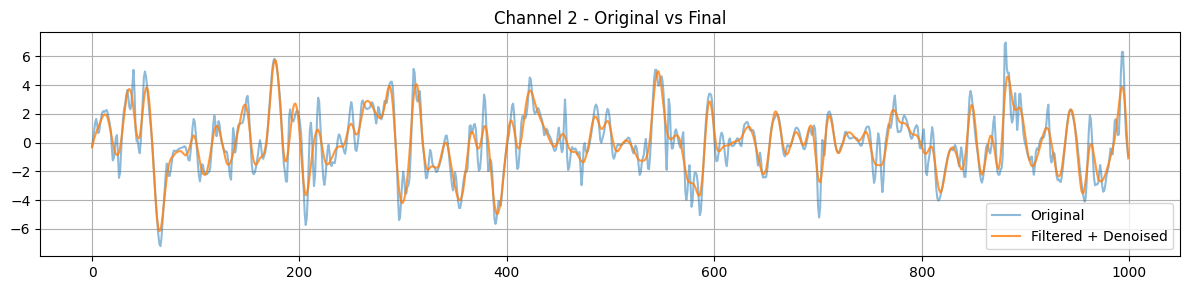

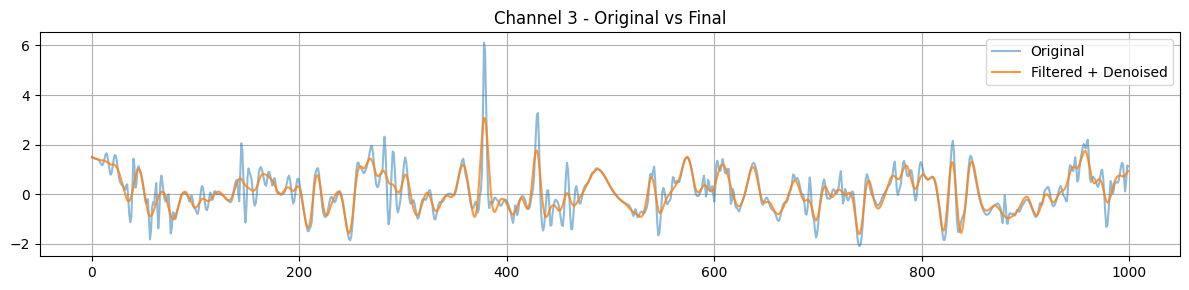

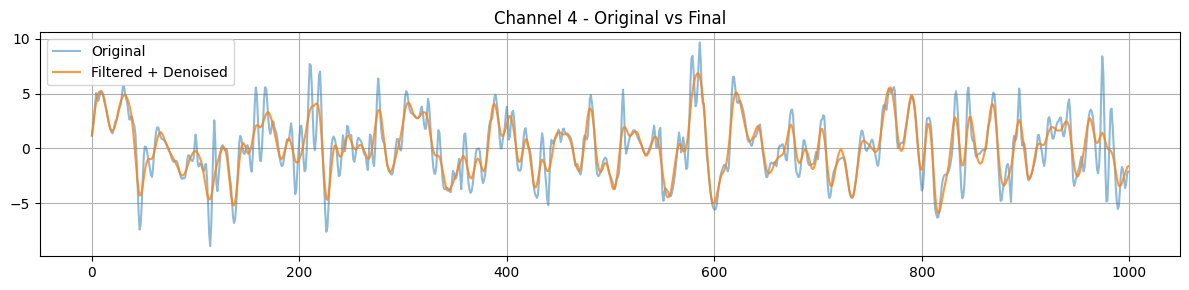

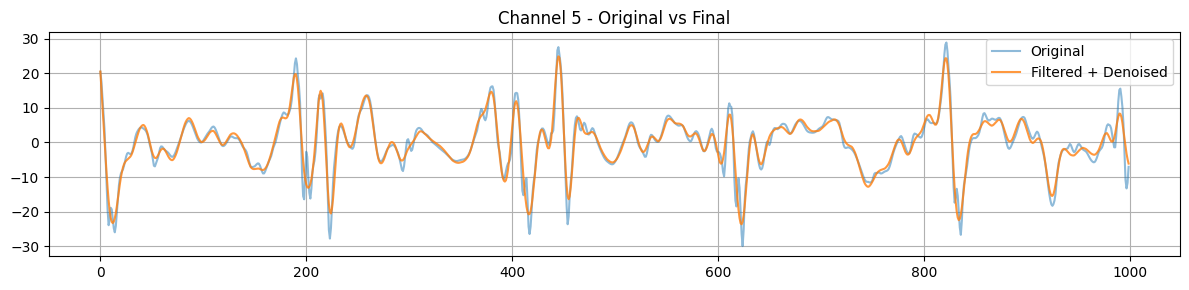


--- Statistik Data ---
Jumlah file CSV ditemukan          : 25
Jumlah total data mentah          : 34,200,000
Jumlah total data setelah filter  : 11,400,000
Jumlah total segmen fitur (X)     : 1,575

Jumlah data per label (setelah mapping):
G1: 225
G2: 450
G3: 600
G4: 150
G5: 150


In [34]:
X_test, y_test, df_test = load_and_preprocess_all_data(test_folder)

In [35]:
df_test['Group'] = df_test['Label'].map(map_faabos_group)

In [36]:
# Gunakan langsung hasil ekstraksi
test_features = X_test
test_labels = y_test

In [37]:
# Encode label test dengan encoder yang sama
test_encoded_labels = label_encoder.transform(test_labels)

In [38]:
# Standarisasi fitur test dengan scaler yang sama
test_scaled_features = scaler.transform(test_features)

In [39]:
# Prediksi dengan model KNN yang sudah dilatih
test_predictions = knn.predict(test_scaled_features)

In [40]:
# Evaluasi performa pada data test
print("Evaluation on Test Data")
print(classification_report(test_encoded_labels, test_predictions, target_names=label_encoder.classes_))

Evaluation on Test Data
              precision    recall  f1-score   support

          G1       0.20      0.16      0.18       225
          G2       0.37      0.54      0.44       450
          G3       0.40      0.44      0.42       600
          G4       0.17      0.05      0.08       150
          G5       0.11      0.02      0.03       150

    accuracy                           0.35      1575
   macro avg       0.25      0.24      0.23      1575
weighted avg       0.31      0.35      0.32      1575



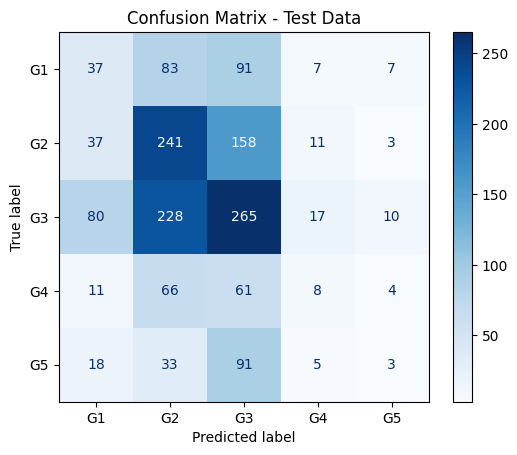

In [41]:
# Confusion Matrix
cm_test = confusion_matrix(test_encoded_labels, test_predictions)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
disp_test.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Data")
plt.show()